## Loss variant experiments

Comparing loss functions given in https://github.com/cwbeitel/tk/blob/master/tk/models/similarity_transformer.py#L30 with keys "kfnet", "simple_cd", and "slicenet".

In [1]:

import csv
from six import StringIO
import tempfile

from tensor2tensor.data_generators import problem
from tensor2tensor.layers import common_layers
from tensor2tensor.models import transformer
from tensor2tensor.utils import registry
from tensor2tensor.utils import t2t_model

from tensor2tensor.data_generators import generator_utils
from tensor2tensor.data_generators import text_problems
from tensor2tensor.utils import metrics

import tensorflow as tf

import tk

from tk.models import similarity_transformer

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys

from tk.experiment import configure_experiment, T2TExperiment

from tk.models import similarity_transformer
from tk.data_generators import function_docstring


### Training

In [ ]:

args = configure_experiment("cs-lv1-simplecd",
                             problem="github_function_docstring",
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_dev",
                             extra_hparams={
                                 "loss_variant": "simple_cd"
                             },
                             num_gpu_per_worker=1,
                             num_steps=2000)

job = T2TExperiment(**args)
job.run()

# cs-lv-simplecd-j1014-0205-1cd0-master-4ud9-0-w3ta2

In [ ]:

args = configure_experiment("cs-lv1-kfnet",
                             problem="github_function_docstring",
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_dev",
                             extra_hparams={
                                 "loss_variant": "kfnet"
                             },
                             num_gpu_per_worker=1,
                             num_steps=2000)

job = T2TExperiment(**args)
job.run()

# cs-lv-kfnet-j1014-0206-a5fa-master-idnx-0-ymfen

In [ ]:

args = configure_experiment("cs-lv1-slicenet",
                             problem="github_function_docstring",
                             hparams_set="similarity_transformer_tiny",
                             model="similarity_transformer_dev",
                             extra_hparams={
                                 "loss_variant": "slicenet"
                             },
                             num_gpu_per_worker=1,
                             num_steps=2000)

job = T2TExperiment(**args)
job.run()

# cs-lv-slicenet-j1014-0206-ee3c-master-jtcc-0-61cr9

INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-14 15:58:50,471] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 3)


[2018-10-14 15:58:51,597] Processing experiment events (1 of 3)


INFO:tensorflow:Processing experiment events (2 of 3)


[2018-10-14 15:58:52,287] Processing experiment events (2 of 3)


INFO:tensorflow:Processing experiment events (3 of 3)


[2018-10-14 15:58:52,881] Processing experiment events (3 of 3)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-14 15:58:53,481] Finished loading event data for comparison.


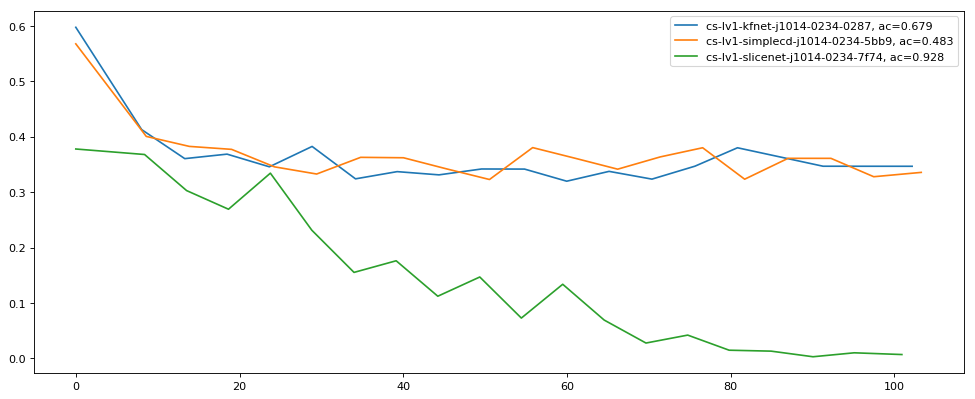

In [3]:

# For now since tk.allen_demo imports tfe this cell has to be run from scratch

from tk.allen_demo import event_data_for_comparison, show_experiment_loss
%matplotlib inline

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-lv1*")
show_experiment_loss(experiment_data)


The "slicenet" loss converges within only 1-2k steps. This seems overly fast. But perhaps the embedding correspondence problem is much easier to learn than e.g. the code inpainting problem.

### Qualitative

In [ ]:
# TODO: Haven't finished this section. In general don't have a clear sense yet of whether the
# above worked.

In order to do inference with the right sub-network we'll need an infer method that makes this distinction, let's try this one:

In [4]:

class SimilarityTransformerInferenceDev(similarity_transformer.SimilarityTransformerDev):

  def body(self, features):
    # Assumes input has both inputs and targets, requiring dummies during
    # inference
    string_embedding = self.encode_string(features["inputs"])
    code_embedding = self.encode_code(features["targets"])
    loss = self.similarity_cost(string_embedding, code_embedding)
    return tf.concat(string_embedding, code_embedding), {"training": loss}

  def infer(self, features=None, **kwargs):
    del kwargs
    if "targets" not in features:
      # Processing doc strings
      features["targets"] = tf.zeros_like(features["inputs"])
      predictions, _ = self(features)
      # Doc string embeddings are the first half of the concatenated output
      # so we'll just return that.
      # len(predictions) can't not be divisible by 2.
      return predicitons[:len(predictions/2)]
    elif "inputs" not in features:
      # The reverse, processing code, yielding second half of concat
      features["inputs"] = tf.zeros_like(features["targets"])
      predictions, _ = self(features)
      return predicitons[len(predictions/2):]
    else:
      raise ValueError("Must specify either inputs or targets.")


In [5]:

# Setup helper functions for encoding and decoding
def encode(encodable, output_str=None, encoders=None, mode="doc_string"):
  """Input str to features dict, ready for inference"""
  mode_keys = {"doc_string": "inputs", "code": "targets"}
  mode_key = mode_keys[mode]
  encoded = encoders[mode_key].encode(encodable) + [1]  # add EOS id
  batched = tf.reshape(encoded, [1, -1, 1])  # Make it 3D.
  return {mode_key: batched}


In [ ]:

tmp_dir = "/mnt/nfs-east1-d/tmp"
data_dir = "/mnt/nfs-east1-d/data"
similarity_problem = function_docstring.GithubFunctionDocstring()
similarity_problem.generate_data(data_dir, tmp_dir)


In [ ]:

hparams = similarity_transformer.similarity_transformer_tiny()
hparams.data_dir = "/mnt/nfs-east1-d/data"
p_hparams = similarity_problem.get_hparams(hparams)
model = similarity_transformer.SimilarityTransformerInferenceDev(hparams, tf.estimator.ModeKeys.TRAIN, p_hparams)


In [ ]:

ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-lv1-slicenet/cs-lv1-slicenet-j1014-0234-7f74/output/model.ckpt-2000"


In [6]:

# TODO: Compute a heatmap showing pair/non-pair distances. Should be low on diagonal.

def show_pair_non_pair_distances():

    num_steps = 10
    doc_emb_last = None
    code_emb_last = None

    for step in range(0, num_steps):

        example = tfe.Iterator(train_dataset).next()

        doc_emb = model.infer({"inputs": example["inputs"]})
        code_emb = model.infer({"inputs": example["targets"]})

        print("Dist for true pair: %s" % model.loss(doc_emb, code_emb, "kfnet"))

        if doc_emb_last is not None:

          print("Dist for false pair: %s" % model.loss(doc_emb, code_emb_last, "kfnet"))
          # Assuming examples are well shuffled...

        print('\n')
        doc_emb_last = doc_emb
        code_emb_last = code_emb


with tfe.restore_variables_on_create(ckpt_path):
  show_pair_non_pair_distances()


In [ ]:

doc_string1 = "print the fibonacci sequence in o(2^n)"
code_string1 = "def f(n): if n == 0: return 0 elif n == 1: return 1 else: return f(n-1)+f(n-2)"

doc_string2 = "print the fibonacci sequence quickly"
code_string2 = "def f(n): return ((1+sqrt(5))**n-(1-sqrt(5))**n)/(2**n*sqrt(5))"

doc_string3 = "start a flask web server"
code_string3 = "start a web server using flask"

encoders = similarity_problem.feature_encoders(hparams.data_dir)
encoded_string = encode(query, encoders=encoders, mode="doc_string")

# TODO: Loop through these, performing inference for each pair and computing distances between all pairs.

#with tfe.restore_variables_on_create(ckpt_path):
#  output = model.infer(encoded)
#  doc_string_embedding = translate_model.infer(encoded_inputs)["outputs"]
